This serves as a playground to test different architectures, methods, and setups of neural networks. It uses the automated basic neural network I created.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import seaborn as sns
import torch

In [66]:
#X,y = make_blobs(n_samples=5000,n_features = 2, centers = 4,cluster_std= 1.2, center_box=(-15,15))
#df = pd.DataFrame(X,columns = [f"feature_{i}" for i in range(X.shape[1])])
#df['target_1'] = y
df = pd.read_csv('toydf.csv')
df

,feature_0,feature_1,target_1
0,-11.542250,2.619277,2
1,-11.223767,-7.119581,3
2,-1.211414,-3.989748,1
3,7.261602,9.817374,0
4,-7.782191,6.065323,2
...,...,...,...
4995,-1.776268,-1.688066,1
4996,-12.332780,-7.115550,3
4997,4.220348,8.502958,0
4998,6.948812,9.507502,0


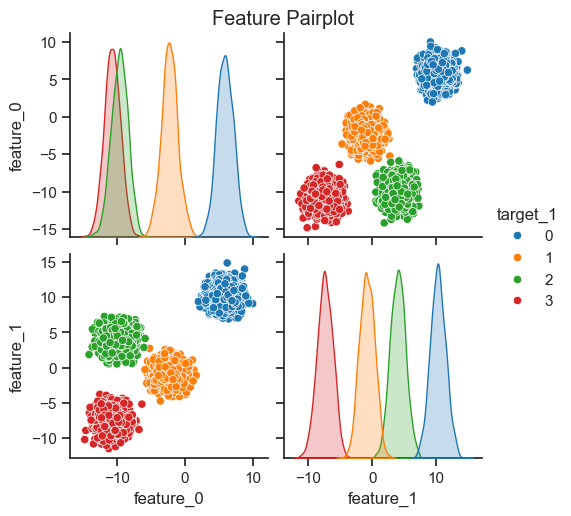

In [67]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="target_1", palette="tab10")
plt.suptitle("Feature Pairplot", y=1.02)
plt.show()

One-hot encoding

In [68]:
target_train = torch.tensor(df['target_1'].values)
target_one_hot = torch.nn.functional.one_hot(target_train,num_classes=4)

df_one_hot = pd.DataFrame(target_one_hot.numpy(), columns=['class_0','class_1','class_2','class_3'])
df_new = pd.concat([df.drop(columns=['target_1']),df_one_hot],axis=1)

df_train,df_test = train_test_split(df_new, test_size=0.25,random_state=50)

X_train = df_train.drop(columns=['class_0','class_1','class_2','class_3']).values
y_train = df_train[['class_0', 'class_1', 'class_2', 'class_3']].values

X_test = df_test.drop(columns=['class_0','class_1','class_2','class_3']).values
y_test = df_test[['class_0', 'class_1', 'class_2', 'class_3']].values

Activation functions.

In [69]:
def relu(x):
    return np.maximum(0,x)

def relu_d(x):
    return np.where(x>0,1,0)

def lrelu(x,alpha=0.01):
    return np.where(x>0,x,alpha*x)

def lrelu_d(x,alpha=0.01):
    return np.where(x>0,1,alpha)

def softmax(x):
    exp_x = np.exp(x-np.max(x,axis=1,keepdims=True))
    return exp_x / np.sum(exp_x,axis=1,keepdims=True)

def sigmoid(x):
    return 1/(1+np.exp(-x))

Configure weights based on the numbers of neurons per layer.

In [70]:
def weight_configure(input_dim,neurons): #fully automated weight creation based on neuron and layer configuration
    w1 = np.random.normal(loc=0.0, scale=np.sqrt(2 / input_dim), size=(input_dim+1, neurons[0])) #he initialization of weights
    weights = []
    for l in range(len(neurons[1:])):
        he_init = np.sqrt(2 / neurons[l])
        w = np.random.normal(loc=0.0, scale=he_init, size=(neurons[l]+1, neurons[l+1]))
        weights.append(w)
    return [w1] + weights  


Forward propagation.

In [71]:
def forward(X,weights,activation,activation_o): #fully automated forward prop
    pre_act = []
    act = []
    
    Xc = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # this must not be altered
    X_working = Xc.copy()  # this will be altered

    for weight in weights[:-1]: #every weight besides the last
        a = X_working @ weight
        pre_act.append(a)
        X_working = activation(a)
        X_working = np.concatenate([np.ones((X_working.shape[0], 1)),X_working], axis=1) #add bias to the activated function
        act.append(X_working)

    a_final = X_working @ weights[-1] #last weight
    pre_act.append(a_final)
    y = activation_o(a_final)

    return Xc, pre_act, act, y

Back propagation (gradient output).

In [72]:
def backward(Xc,pre_act,act,y,t,weights,activation_d): #fully automated backprop
    deltas = []
    dw = []

    delta = y - t #make sure to change this if it's mathematiclly different
    deltas = [delta]
    
    for i in reversed(range(len(weights)-1)):
        W_next = weights[i+1][:-1,:]
        delta = activation_d(pre_act[i]) * (delta @ W_next.T) 
        deltas.insert(0,delta)

    layer_inputs = [Xc] + act[:]
    
    for acts,d in zip(layer_inputs,deltas):
        dw.append(acts.T @ d)
    
    return dw

SGD algorithm.

In [73]:
def sgd(weights,gradients,eta):
    new_weights = []
    for W_i, dw_i in zip(weights, gradients):
        newW = W_i - eta*dw_i
        new_weights.append(newW)
    return new_weights

Mini-batch SGD training algorithm encasing all functions before it.

In [74]:
def train_mini_batch(X,t,eta,epochs,batch_size,neurons,activation,activation_d,activation_o):
    loss_list = []
    epoch_list = []
    weights = weight_configure(X.shape[1],neurons)
    N = X.shape[0]
    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices]

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size]
            t_batch = t[i:i+batch_size]
            Xc, pre_act, act, y = forward(X_batch,weights,activation,activation_o)
            gradients = backward(Xc,pre_act,act,y,t_batch,weights,activation_d)
            weights = sgd(weights,gradients,eta)
        
        _,_,_,y_full = forward(X,weights,activation,activation_o)
        eps = 1e-8
        loss = -np.mean(np.sum(t * np.log(y_full + eps), axis=1))
        loss_list.append(loss)
        epoch_list.append(epoch)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f}, mean = {np.mean(y_full):.4f}")
    
    return y_full, weights, loss_list, epoch_list

Hyperparameter tuning.

In [ ]:

######## Hyperparameters ########
eta = 0.0001
epochs = 1000
batch_size = 32
neurons = np.array([30,30,4]) #make sure the output corresponds with the amount of target columns
activation = relu #activation function for all hidden layers besides output
activation_d = relu_d #derivative of that activation function
activation_o = sigmoid #activation function for the output layer
################################

Prediction and loss results.

In [76]:
_,o_weights,loss_list,epoch_list = train_mini_batch(X_train,y_train,eta,epochs,batch_size,neurons,activation,activation_d,activation_o)
_,_,_,y_test_final = forward(X_test,o_weights,activation,activation_o)
y_pred = np.zeros_like(y_test_final)
y_pred[np.arange(len(y_test_final)), np.argmax(y_test_final, axis=1)] = 1



Epoch 0: Loss = 0.316021, mean = 0.2586
Epoch 100: Loss = 0.004701, mean = 0.2504
Epoch 200: Loss = 0.002458, mean = 0.2502
Epoch 300: Loss = 0.001829, mean = 0.2501
Epoch 400: Loss = 0.001483, mean = 0.2501
Epoch 500: Loss = 0.001268, mean = 0.2501
Epoch 600: Loss = 0.001085, mean = 0.2500
Epoch 700: Loss = 0.000951, mean = 0.2500
Epoch 800: Loss = 0.000857, mean = 0.2500
Epoch 900: Loss = 0.000788, mean = 0.2500


Epoch vs Loss graph, very important and ultimately shows us the performance of my model!

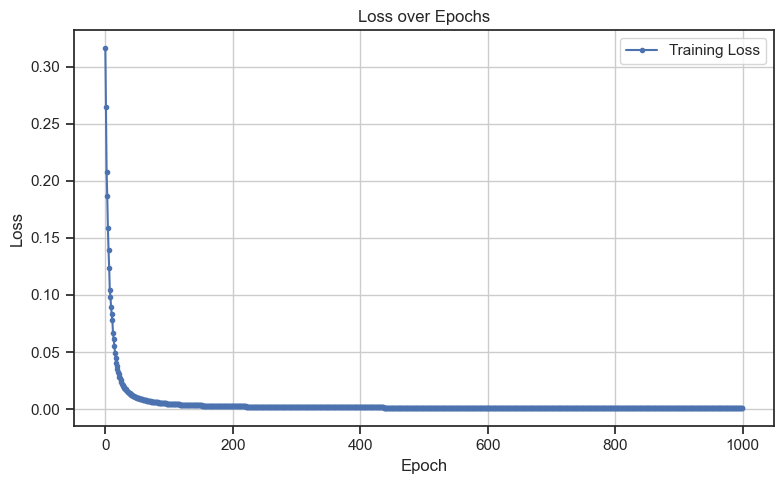

In [77]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_list)), loss_list, label='Training Loss', marker='o', markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Scoring.

accuracy:  1.0
precision:  1.0
recall 1.0
f1: 1.0


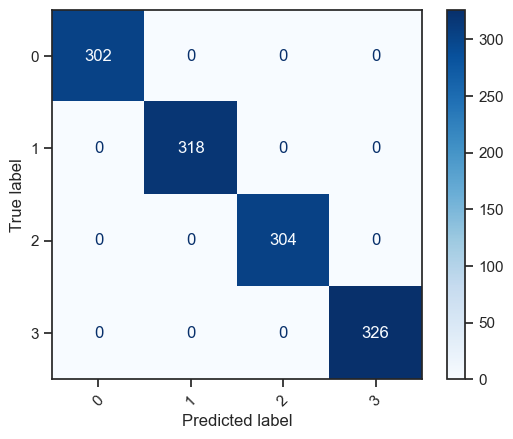

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
#diagonals: correct predictions, Offdiagonals: misclassifications


#compares predictions with test target values and scores them

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("accuracy: ", accuracy)
print("precision: ",precision)
print("recall", recall)
print("f1:", f1)

Transfer learning: We "freeze" some of the weights

In [79]:
def sgd_transfer(weights,gradients,eta,freeze_layers):
    new_weights = []
    for i,(W_i, dw_i) in enumerate(zip(weights, gradients)):
        if i < freeze_layers:
            new_weights.append(W_i)
        else:
            newW = W_i - eta*dw_i
            new_weights.append(newW)
    return new_weights

def train_mini_batch_transfer(X,t,eta,epochs,batch_size,activation,activation_d,activation_o,weights,freeze_layers):
    o_weights = weights
    N = X.shape[0]
    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices]

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size]
            t_batch = t[i:i+batch_size]
            Xc, pre_act, act, y = forward(X_batch,o_weights,activation,activation_o)
            gradients = backward(Xc,pre_act,act,y,t_batch,o_weights,activation_d)
            o_weights = sgd_transfer(o_weights,gradients,eta,freeze_layers)
        if epoch % 1000 == 0:
            _,_,_,y_full = forward(X,o_weights,activation,activation_o)
            eps = 1e-8
            loss = -np.mean(np.sum(t * np.log(y_full + eps), axis=1))
            print(f"Epoch {epoch}: Loss = {loss:.6f}, z3 mean = {np.mean(y_full):.4f}")
    return y_full, o_weights
